In [29]:
import numpy as np
from matplotlib import pyplot as plt
import peakutils
from pylibneteera.signal_processing.utils import fourier_transform, peaks, myremez
from pylibneteera.utils.plotters import plot_gt, plot_peaks
from pylibneteera.utils.utils import break_into_windows
from pylibneteera.datasets.loader import get_session_by_id

In [198]:
import os
import pandas as pd

def get_session_by_id1(identity=None,
                      sessions_list_path=os.path.join(os.getcwd(), 'pylibneteera', 'datasets', 'sessions_list.csv'),
                      data_loc=None):
    sessions = pd.read_csv(sessions_list_path)
    my_session = sessions[sessions.id == identity].iloc[0]
    return get_session_raw_data1(data_loc=data_loc, params=my_session)


def get_session_raw_data1(data_loc=None, params=None):

    base_folder_path = os.path.normpath(params.base_folder)
    raw_path = os.path.join(data_loc, base_folder_path, params.base_filename)
    label_path = os.path.join(data_loc, base_folder_path, params.ground_truth_file_name)

    raw_data = np.loadtxt(raw_path).reshape((-1, 16))
    rpm = pd.read_csv(label_path).values

    return raw_data, rpm

In [402]:
root_dir = r"G:\Team Drives\Neteera Virtual Server\Data"

x, y = get_session_by_id(5, data_loc=root_dir)
_, v = get_session_by_id1(25, data_loc=root_dir)

window_length = 2 ** 11
fs = 290
x1 = break_into_windows(x, win_len=window_length, phase=0)
print(x1.shape)
print(y.shape)

(53, 2048, 16)
(403,)


In [249]:
def plot_peaks(x_axis, graph, pk_idx=None):
    pk_mask = np.zeros(len(graph))
    pk_mask[pk_idx] = 1
    pk_mask[pk_mask == 0] = np.nan
    pk_mask = np.multiply(pk_mask, graph)
    plt.plot(x_axis, pk_mask, "g+")

In [379]:
from scipy.signal import butter, lfilter, periodogram, filtfilt, remez, savgol_filter

def myremez(x, fs=290, band=None):
    trans_width = .001  # Width of transition from pass band to stop band, Hz
    numtaps = 300  # Size of the FIR filter.

    assert len(band) % 2 == 0

    edges = [0]
    gains = [0]

    for i in range(len(band) // 2):
        edges += (band[2 * i] - trans_width, band[2 * i], band[2 * i+1], band[2 * i+1] + trans_width)
        gains += (1, 0)

    edges += [.5 * fs]
    
    print(edges[1] * 60)

    taps = remez(numtaps, edges, gains, Hz=fs)
    return lfilter(taps, 1., x)


In [244]:
print(y.shape)

y1 = break_into_windows(y, win_len=window_length, phase=1769)

print(y1.shape)

def ground_truth_hr(data=None, sample_freq=1):
    if data[0].dtype.kind not in np.typecodes['AllInteger']:
        raise ValueError
    av_instantaneous_hr = np.mean(np.ediff1d(np.argwhere(peaks(np.squeeze(data))))) / sample_freq
    return 60 / av_instantaneous_hr

(157399, 1)
(75, 2048, 1)


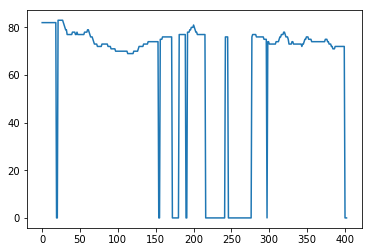

39.94


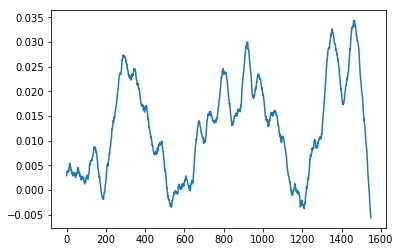

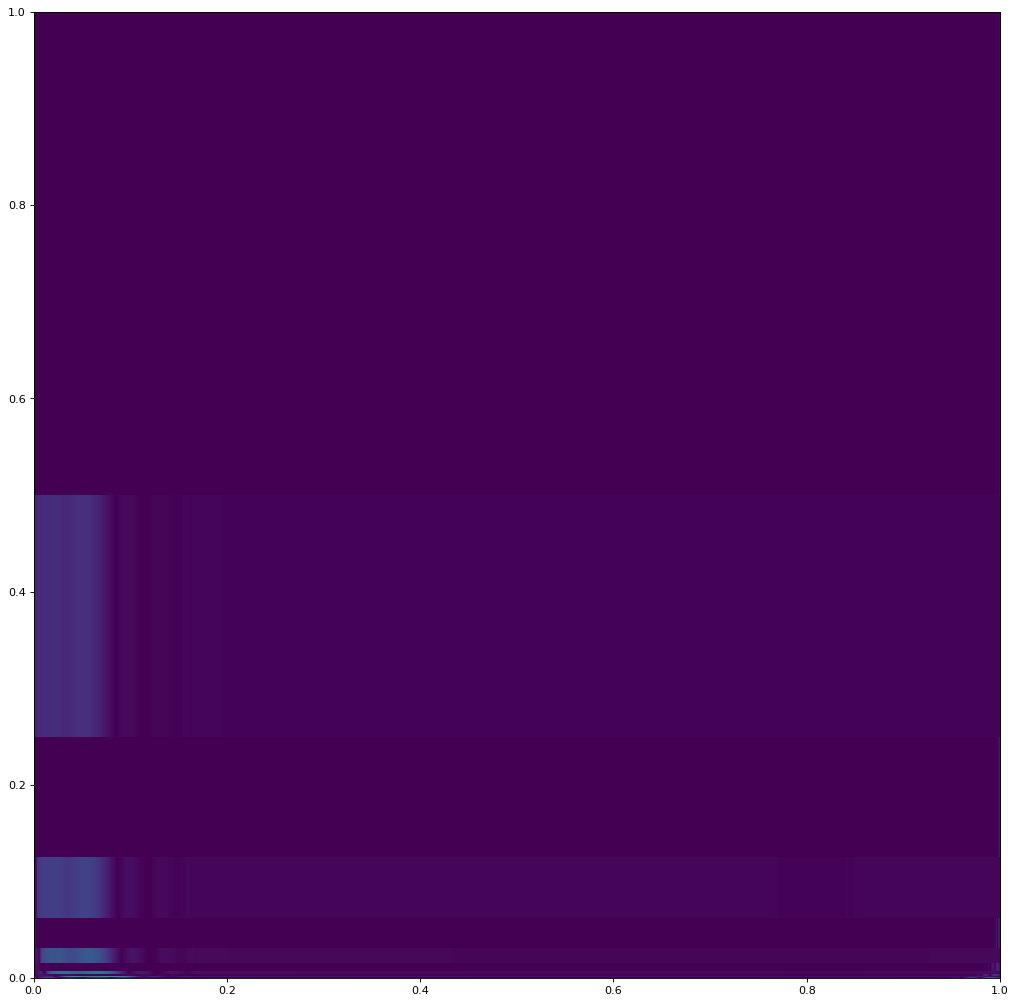

44.94


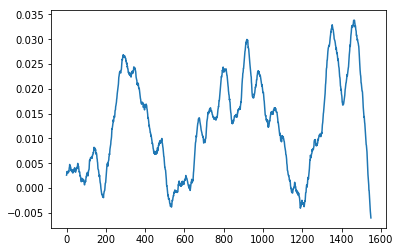

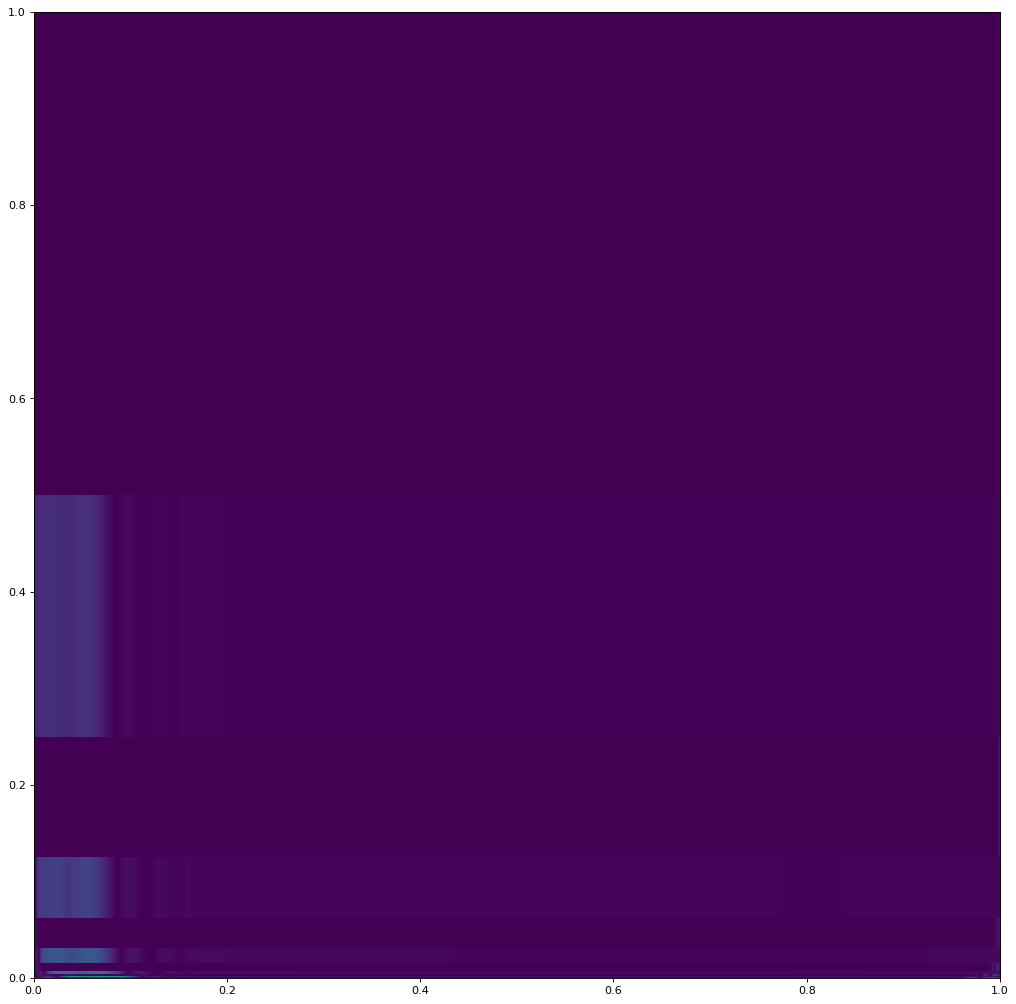

49.94


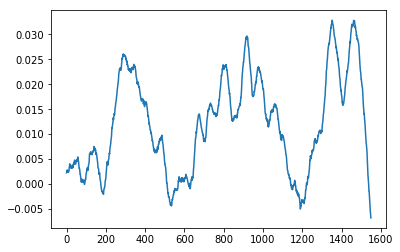

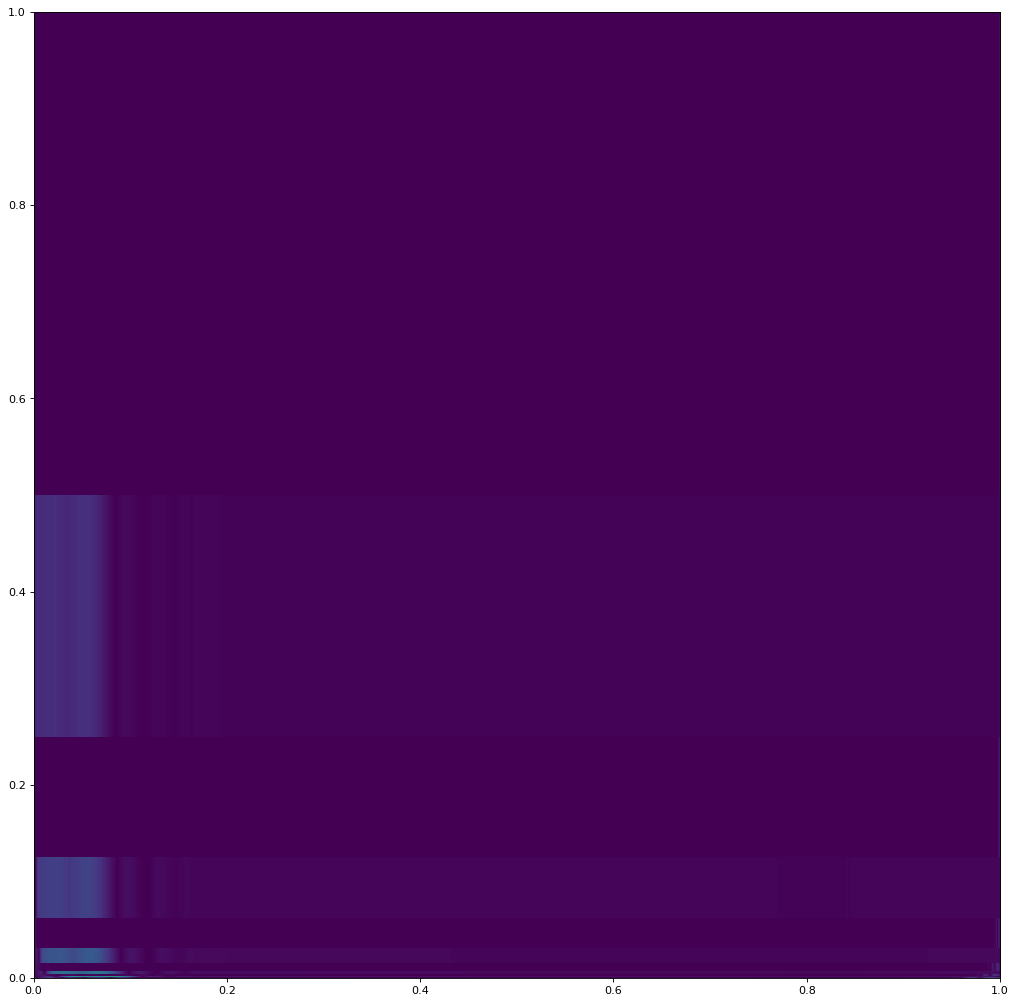

54.94


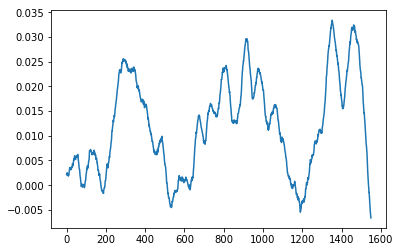

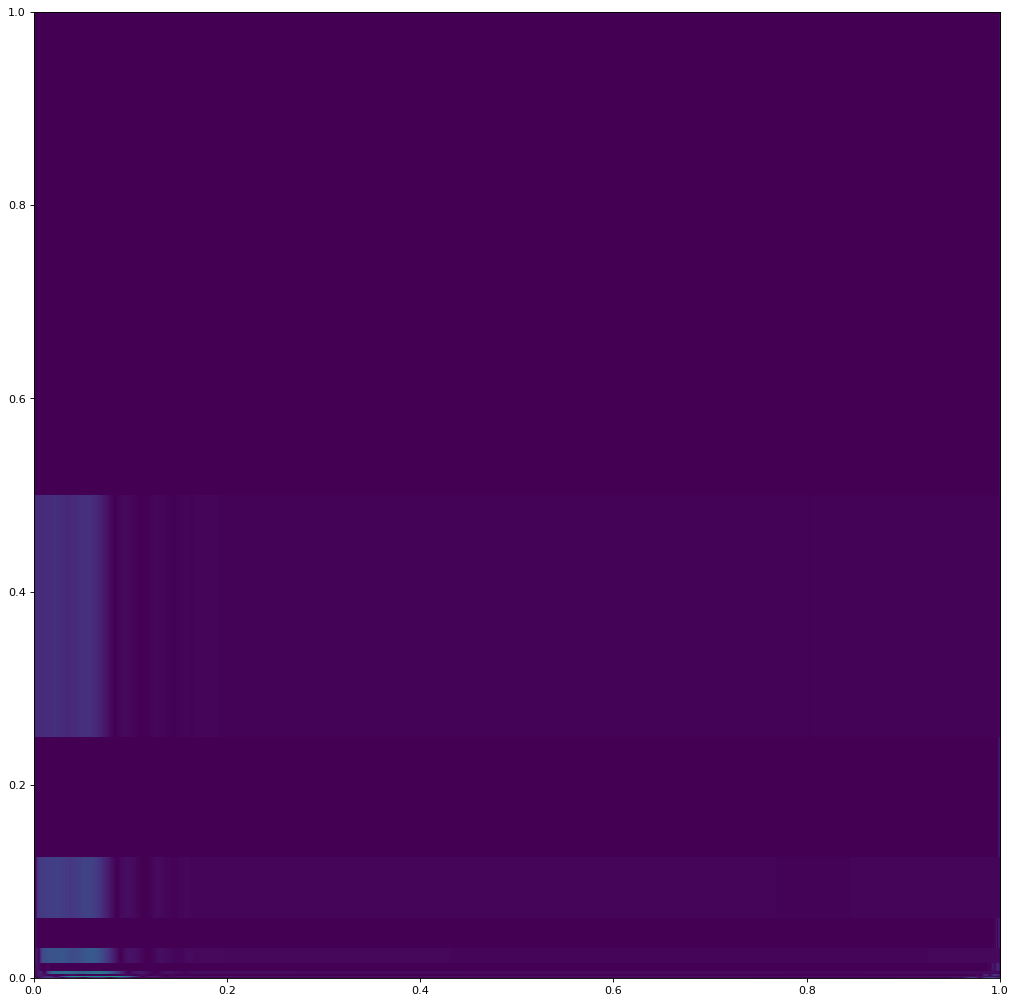

59.94


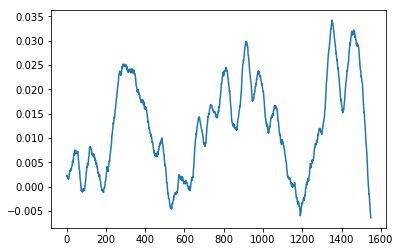

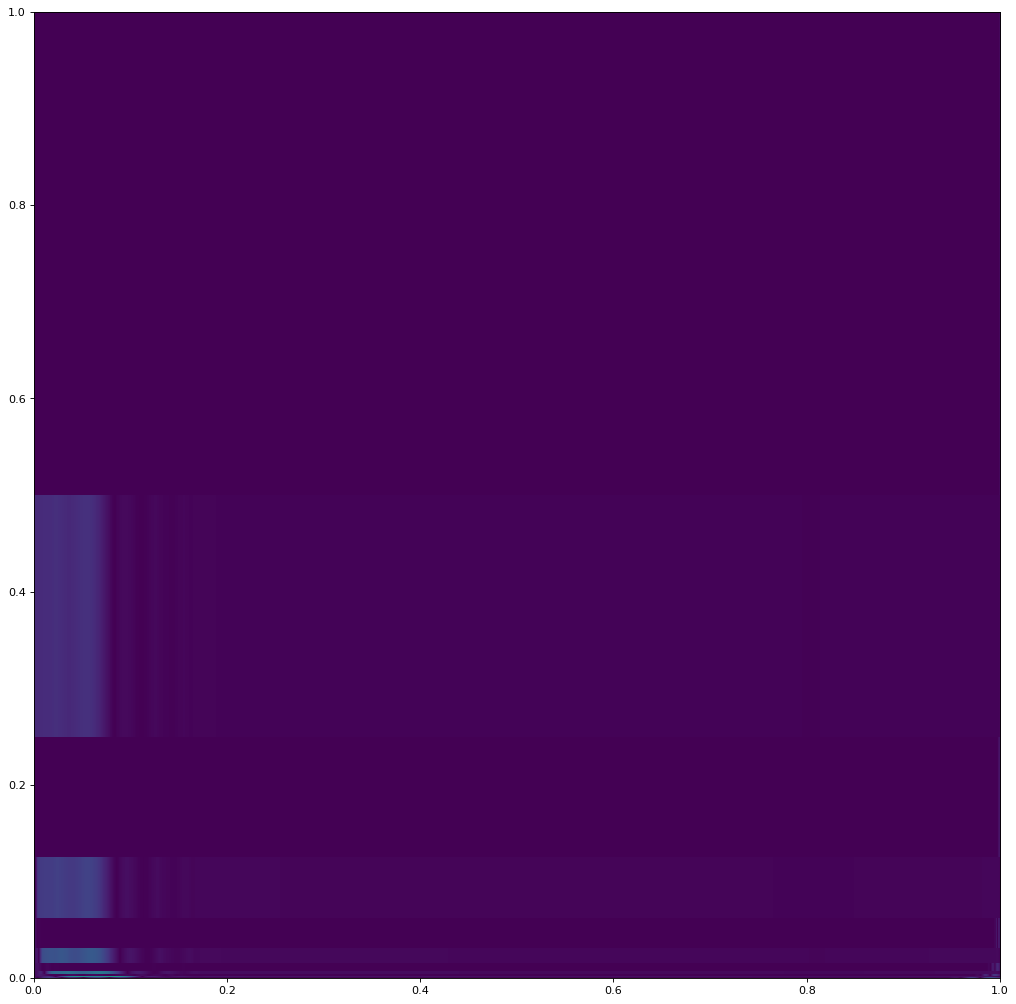

64.94


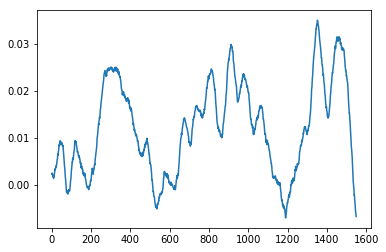

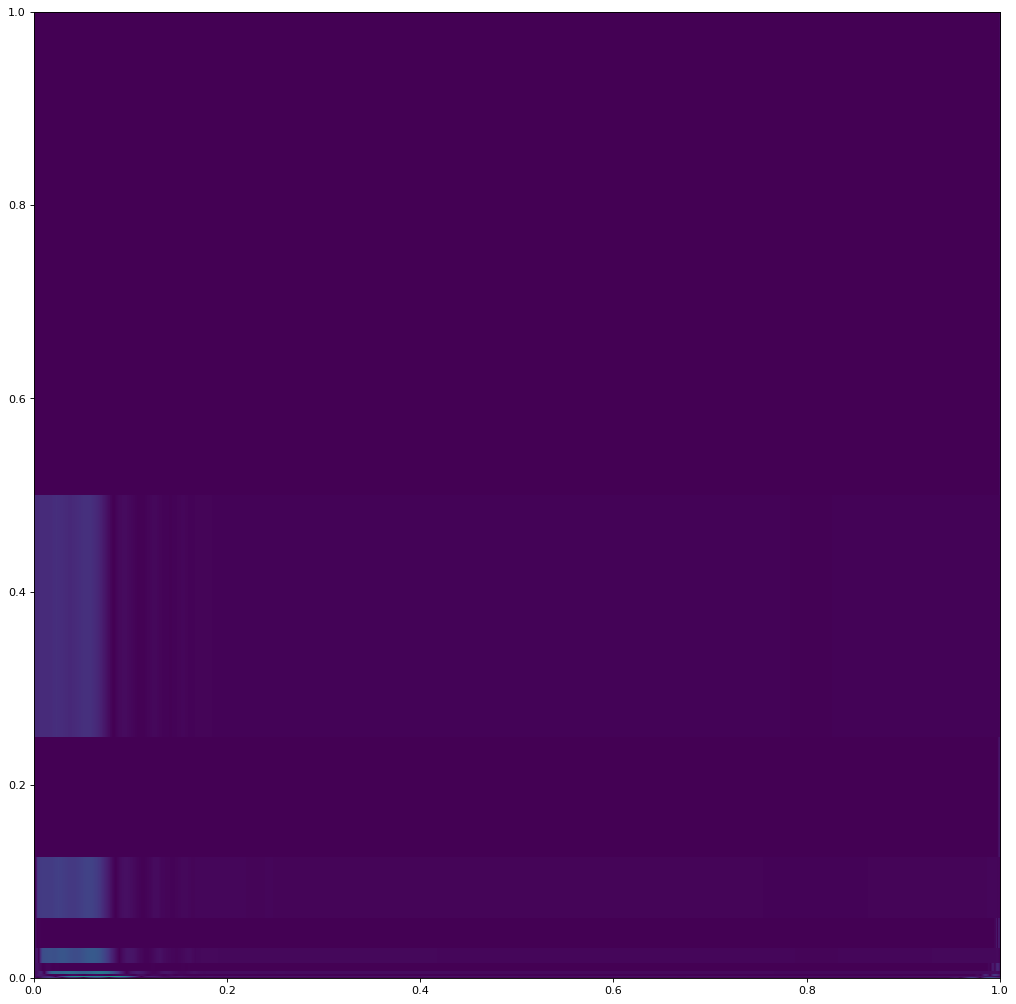

69.94


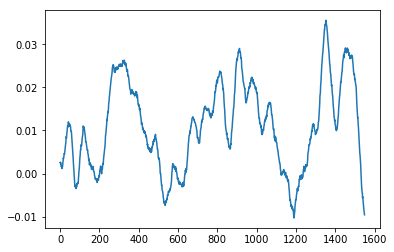

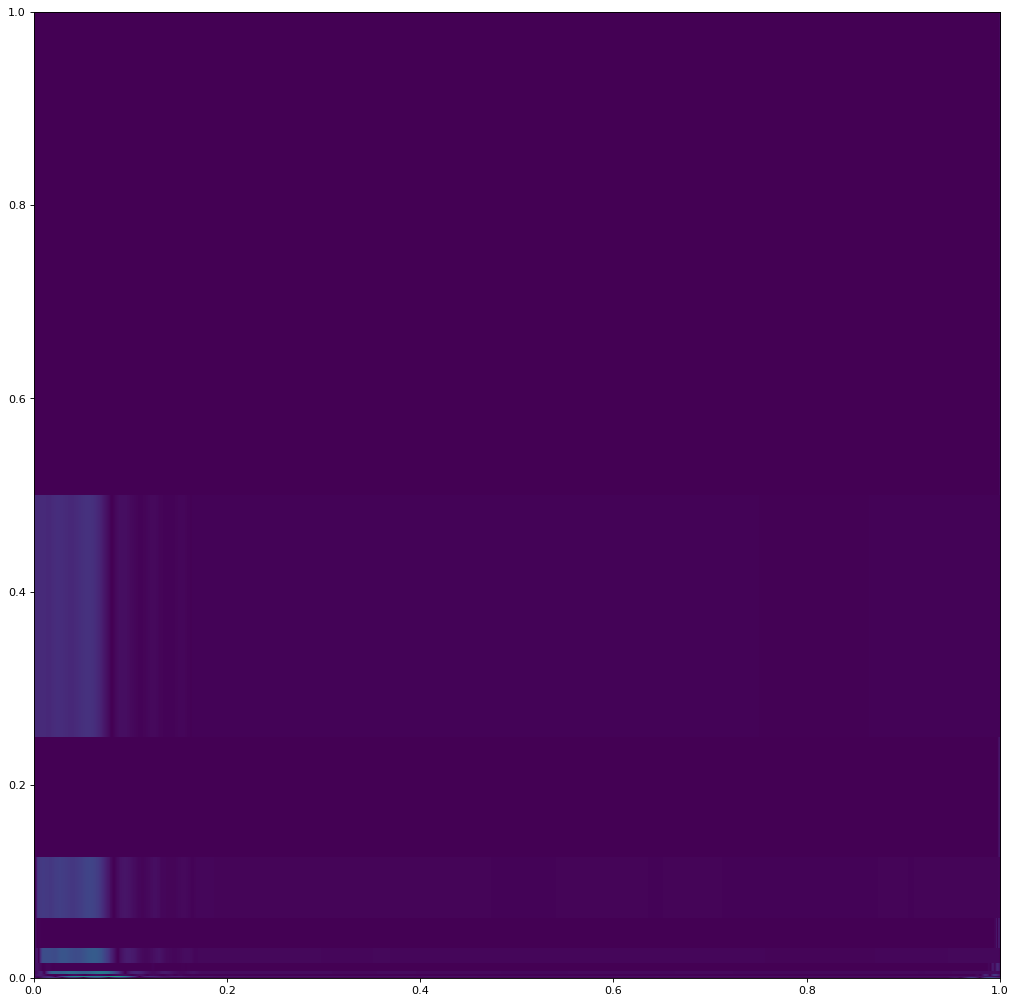

74.94


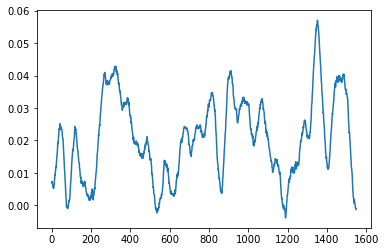

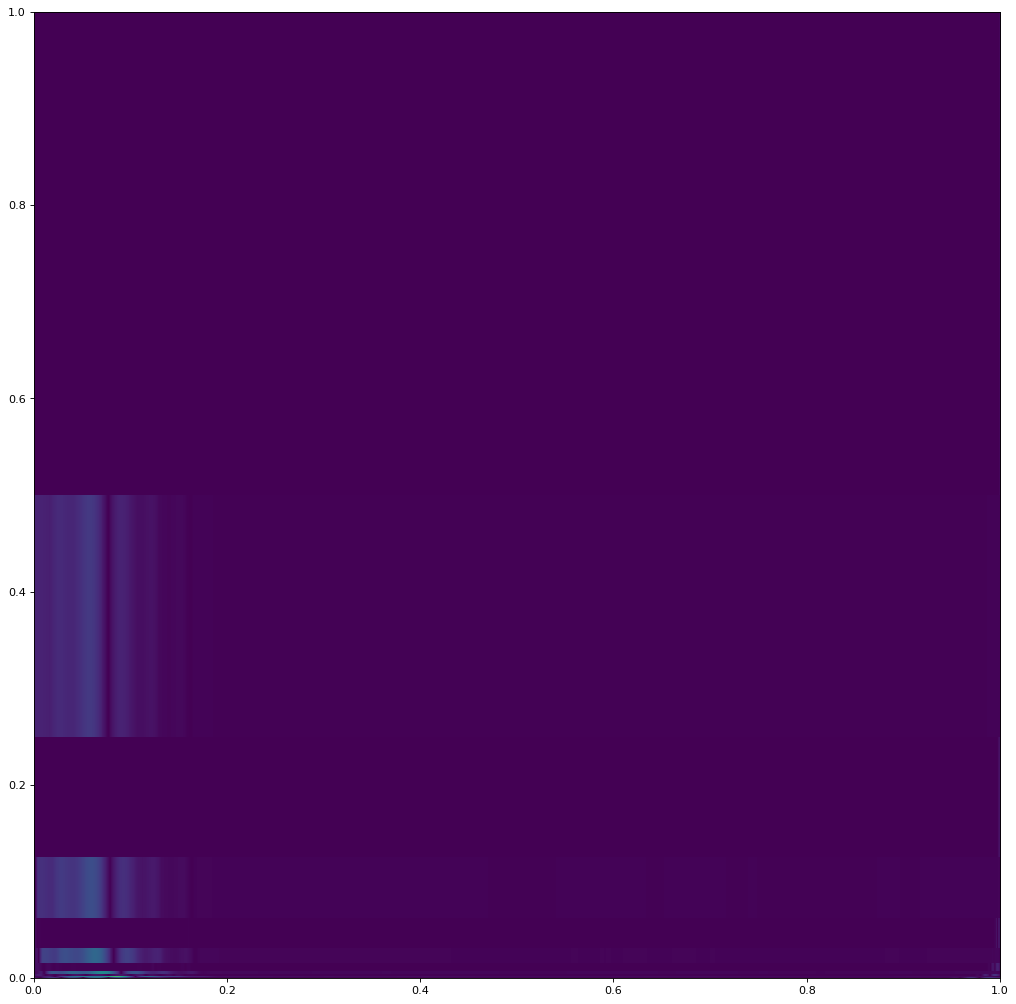

79.94


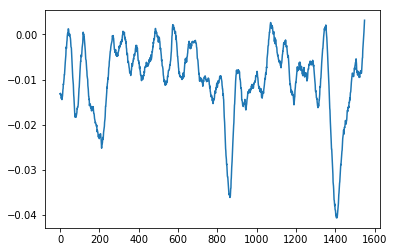

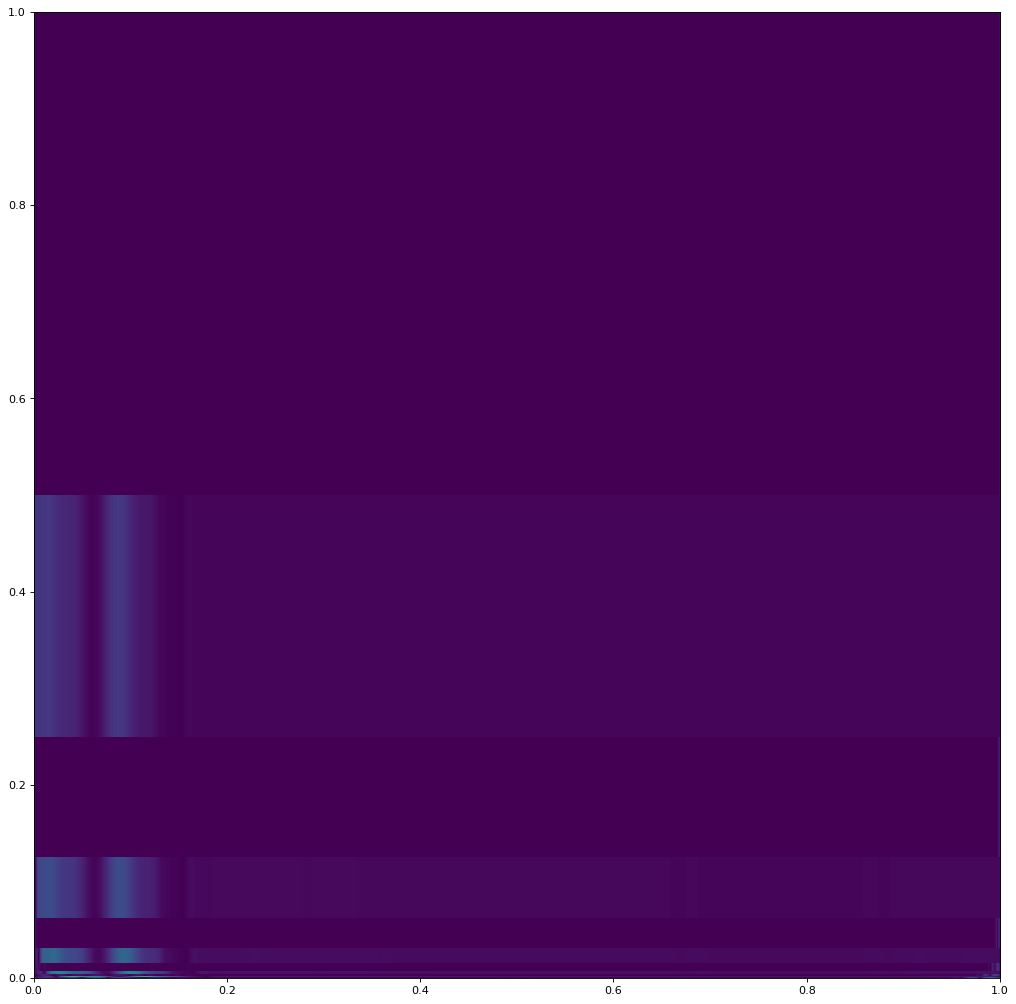

84.94


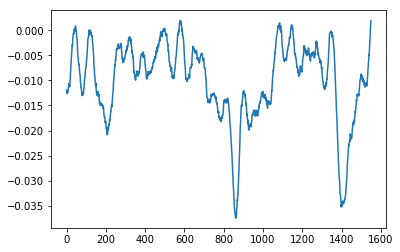

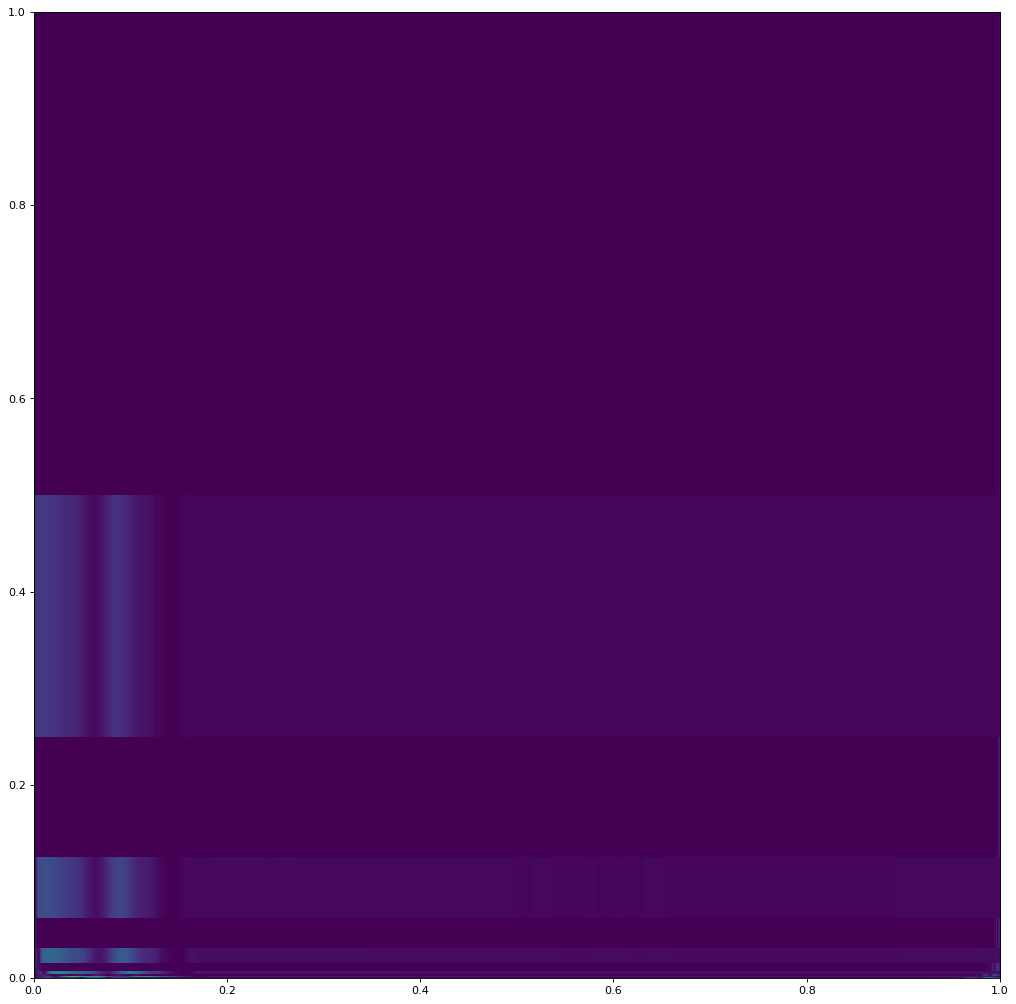

89.94


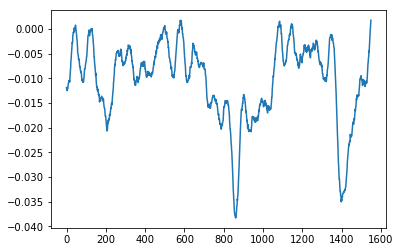

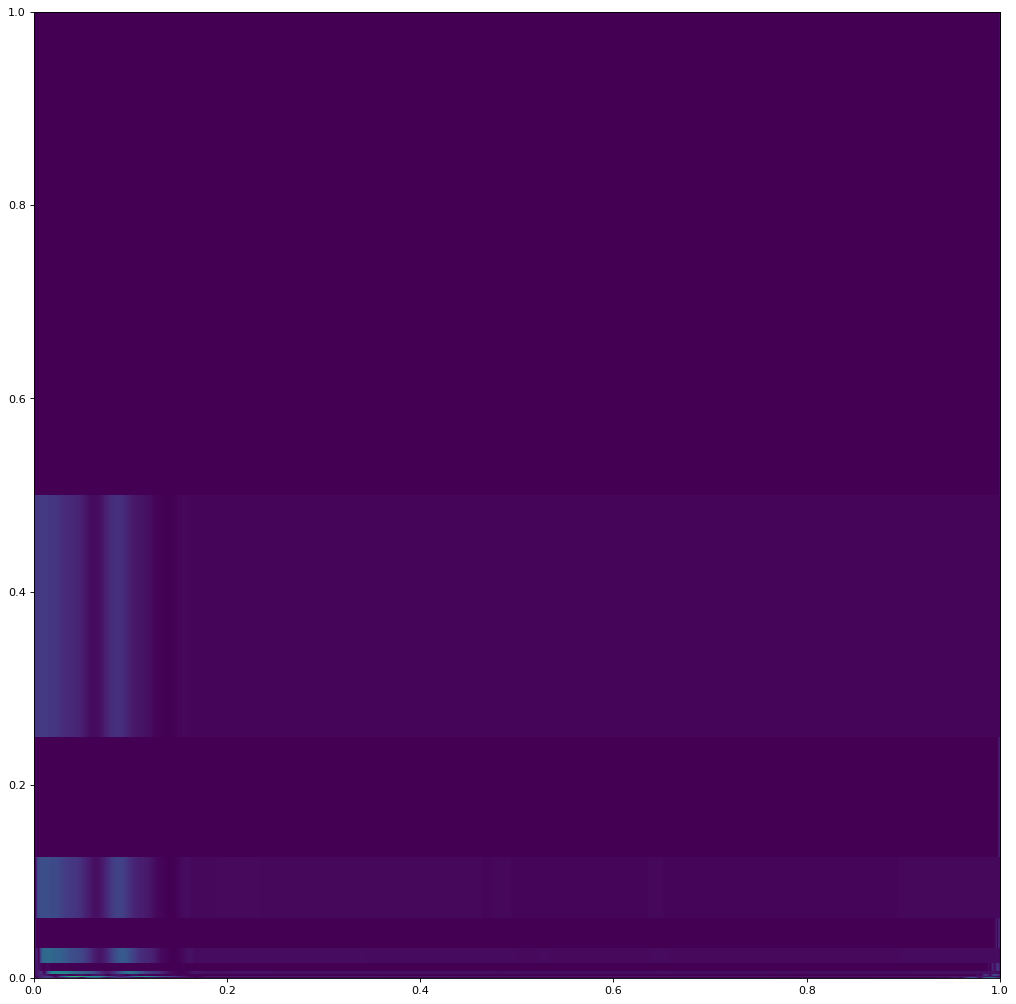

94.94


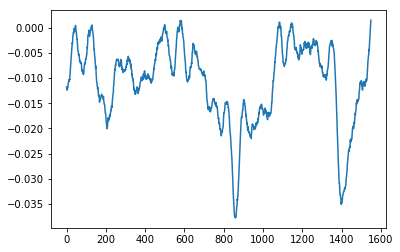

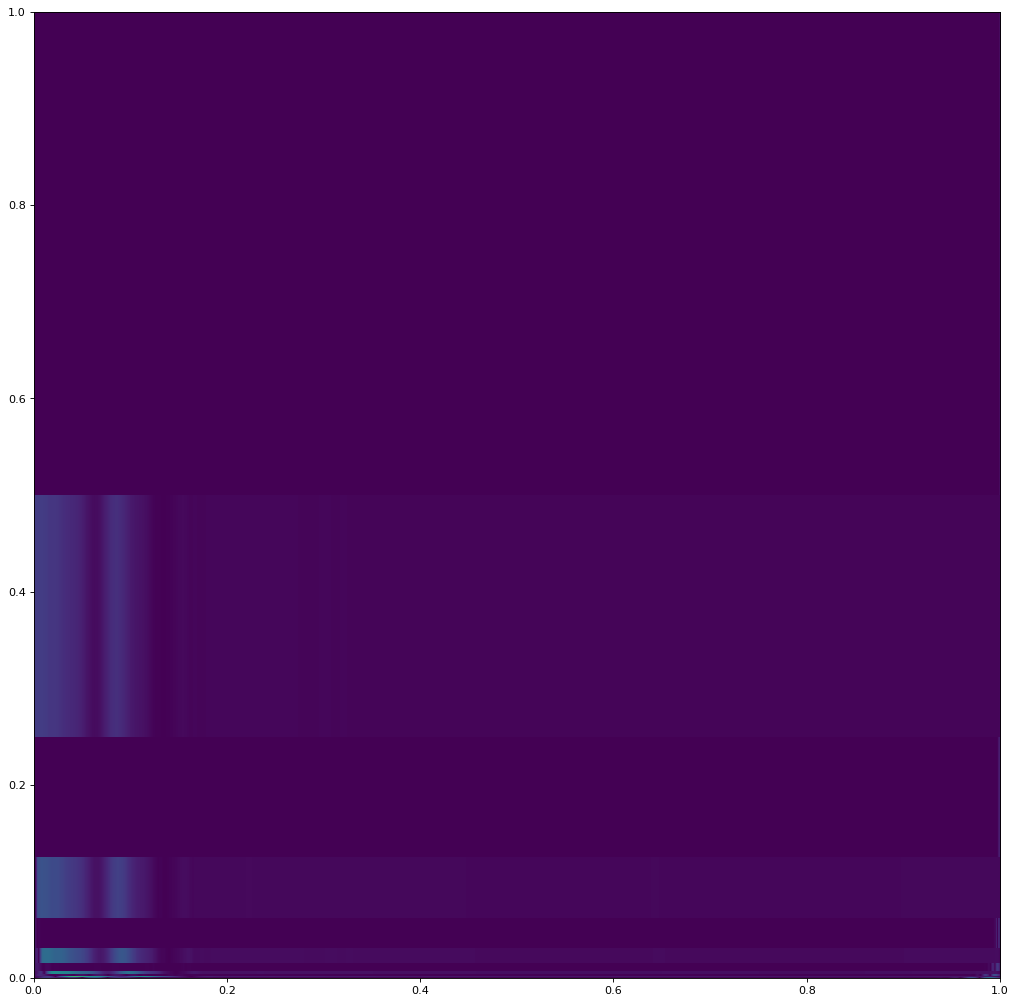

99.94


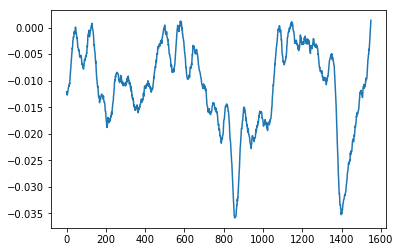

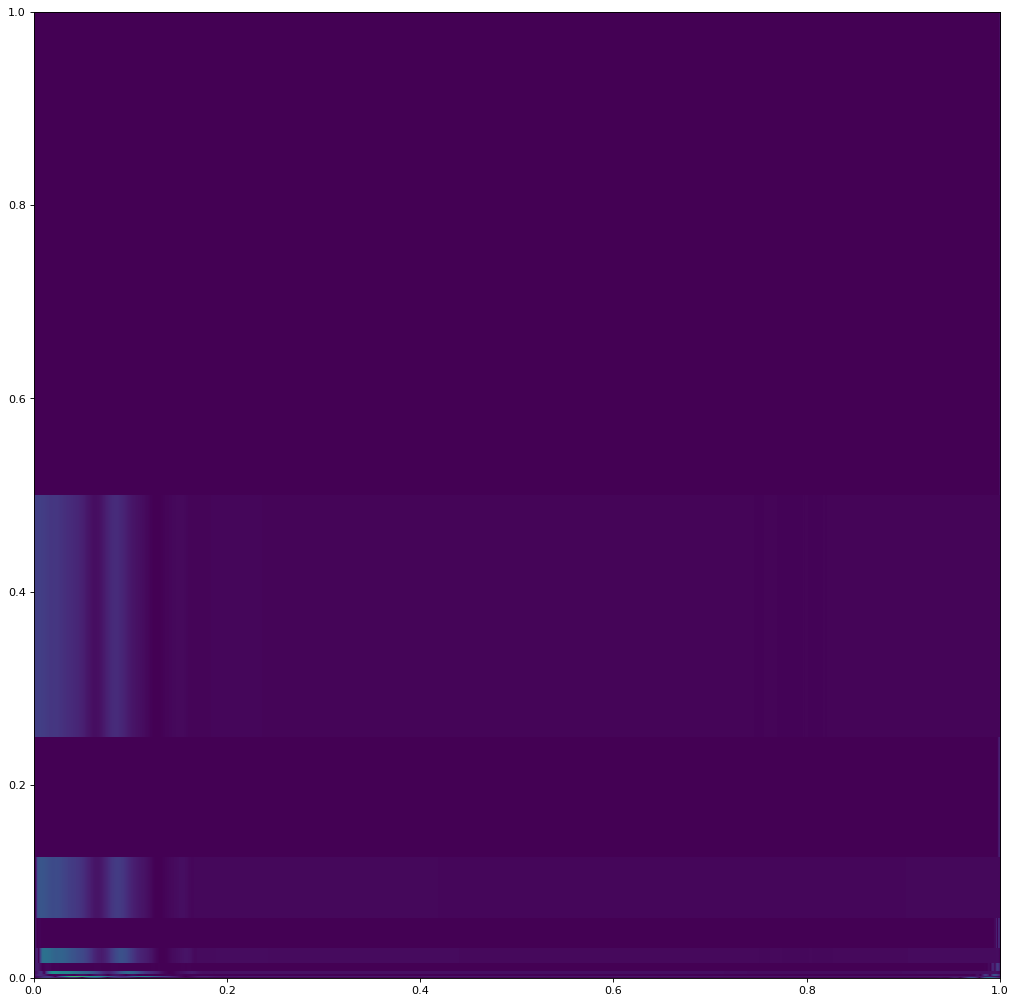

104.94


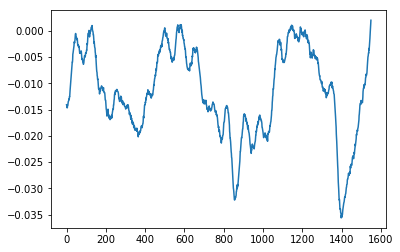

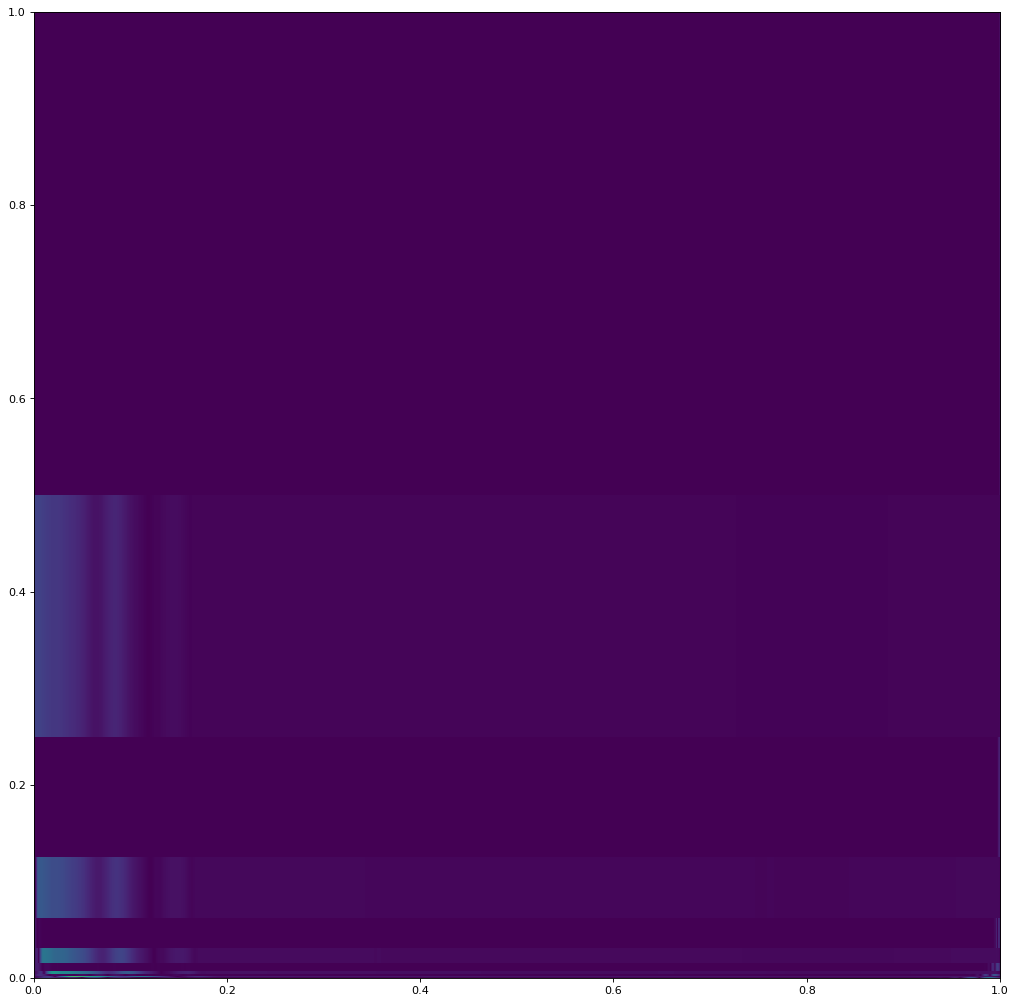

109.94


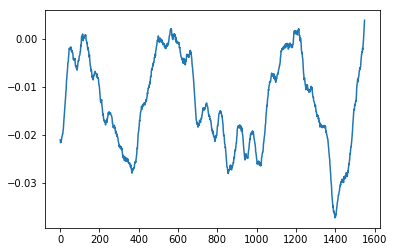

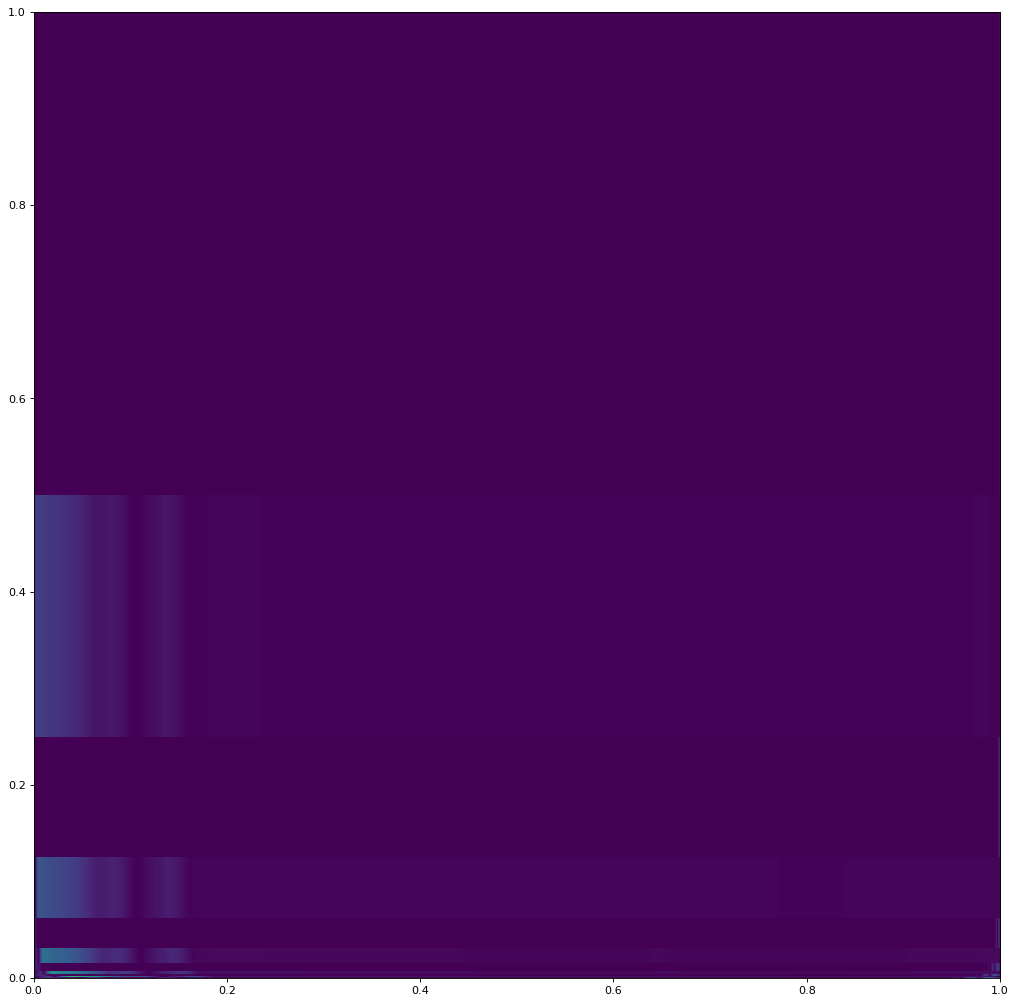

114.94


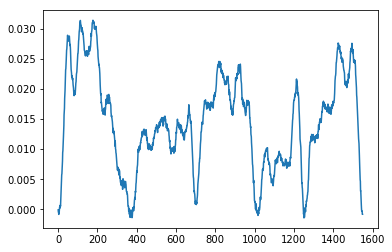

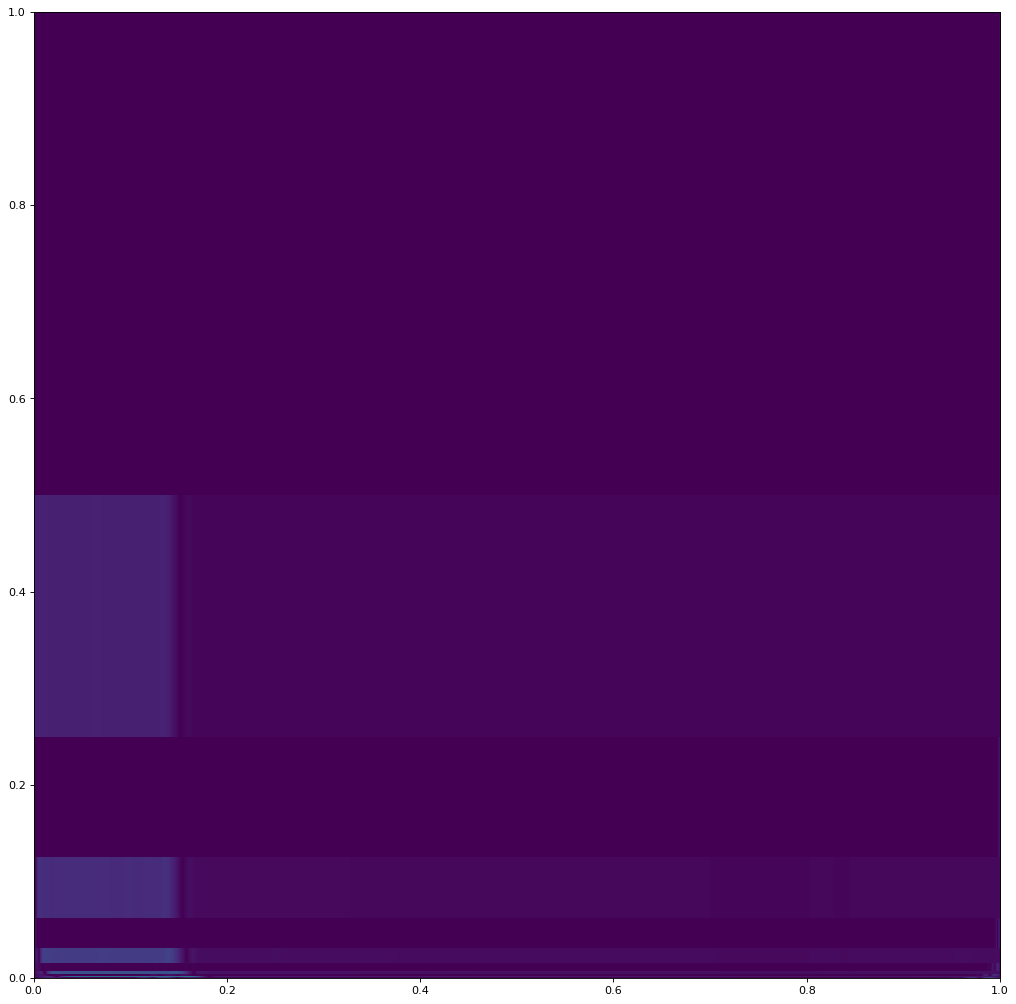

In [405]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

window_number = 10

# gt = []
# for i in range((len(y) - window_length - 20) // 250):
#     gt.append(ground_truth_hr(data=np.squeeze(np.array(y[i * 250 + 10: i * 250 + window_length+ 10])), sample_freq=250))

# v_wl = 410
# gtv = []
# for i in range((len(v) - v_wl - 20) // 50):
#     gtv.append(ground_truth_hr(data=np.squeeze(np.array(v[i * 50 + 10: i * 50 + v_wl + 10])), sample_freq=50))
    
# plt.plot(gt)
# plt.show()
# plt.plot(gtv)
# plt.show()

# second = window_number * window_length // (60 * 290)

# print("GT:  ", gt[second])

plt.plot(y)
plt.show()

for i in range(16):
    a1 = 40 + 5 * i
    band = np.asarray([a1, a1 + 5, 2 * a1, 2 * a1 + 10 , 3 * a1, 3 * a1 + 15]) / 60. 
    r = myremez(x1[window_number, :, 14], band=band)
    r3 = savgol_filter(r, 71, 2, mode='mirror')
    # r2 = lowess(r, range(len(r)), is_sorted=True, delta=10, frac= 1./30, it=3, return_sorted=False)
    # r3 = lowess(r, range(len(r)), is_sorted=True, delta=10, frac= 1./30, it=0, return_sorted=False)
    r3 = (r3 - np.mean(r3)) / np.std(r3)
    # plot_peaks(range(1550), r3[450:2000], np.argwhere(peaks(r3[450:2000])))
    # plt.plot(r1[450:2000])
    # plt.plot(r2[450:2000])
    r4 = r3[450:2000]
    try:
        base = peakutils.baseline(r4, 5)
        plt.plot(r4 - base)
    except ValueError:
        base = peakutils.baseline(-r4, 5)
        plt.plot(r4 + base)
   
    plt.show()
    # r3 = r3 - base
    signal = r3[:lepow2(len(r3))]
    # tree = pywt.wavedec(signal, 'db4')
    tree = pywt.swt(signal, 'db4')
    tree = list(sum(tree, ()))
    swt = pywt.swt(r3, wavelet)    
    scalogram(tree)
    plt.ylim=[0, 0.1]
    plt.show()

Wavelet db10
  Family name:    Daubechies
  Short name:     db
  Filters length: 20
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False
(11, 2, 2048)


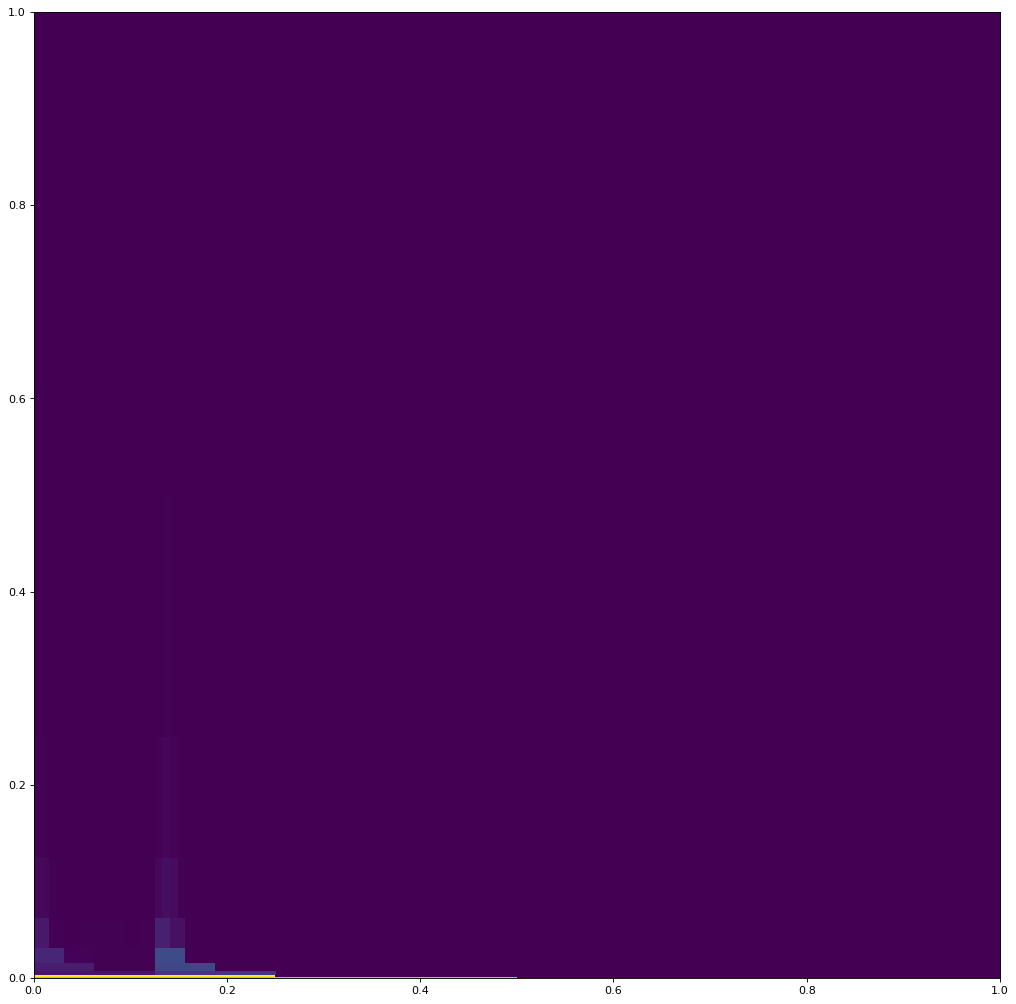

In [289]:
import pywt
wavelet = pywt.Wavelet('db10')
print(wavelet)
signal = r3[:lepow2(len(r3))]
tree = pywt.wavedec(signal, 'db1')
swt = pywt.swt(r3, wavelet)
print(np.asarray(swt).shape)
scalogram(tree)
plt.ylim=[0, 0.1]
plt.show()

In [340]:
# Find the highest power of two less than or equal to the input.
def lepow2(x):
    return 2 ** int(np.floor(np.log2(x)))

# Make a scalogram given an MRA tree.
def scalogram(data):
    bottom = 0

    vmin = min(map(lambda x: min(abs(x)), data))
    vmax = max(map(lambda x: max(abs(x)), data))

    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    
    # ax = fig.add_subplot(2, 1, 1)
    
    plt.gca().set_autoscale_on(False)
    

    for row in range(0, len(data)):
        scale = 2.0 ** (row - len(data))

        plt.imshow(
            np.array([abs(data[row])]),
            interpolation = 'nearest',
            vmin = vmin,
            vmax = vmax,
            extent = [0, 1, bottom, bottom + scale])

        bottom += scale
